### **BPIC 2012 - No milestone**


In [51]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.processor import *
from data.args import *

from tensorflow.keras.utils import to_categorical


### Define the experiment parameters

In [52]:
milestone = 'All' #'A_PREACCEPTED' # 'W_Nabellen offertes', 'All'
subset = "O"
experiment =  'OHE'#'Standard'#'OHE', 'No_loops'
n_size = 5
max_size = 1000 #  3, 5, 10, 15, 20, 30, 50, 95
min_size = 0  # 0, 3, 5, 10, 15, 20, 30, 50

### Setting up the key parameters


In [53]:
# # For local environment only

MY_WORKSPACE_DIR = os.path.join(os.getcwd(),'BPIC12')
MILESTONE_DIR = os.path.join(os.path.join(MY_WORKSPACE_DIR, milestone),experiment)

In [54]:
args = get_parameters('bpic12', MILESTONE_DIR, MY_WORKSPACE_DIR, milestone, experiment,n_size)
args

{'folder': 'c:\\Users\\20182009\\Documents\\Master DSAI\\y2 q1\\2IMI00 seminar process analytics\\replicationStudy\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC12\\All\\OHE\\output_files',
 'lstm_act': None,
 'dense_act': None,
 'optim': 'Adam',
 'norm_method': 'lognorm',
 'model_type': 'shared_cat',
 'l_size': 50,
 'n_size': 5,
 'file_name': 'c:\\Users\\20182009\\Documents\\Master DSAI\\y2 q1\\2IMI00 seminar process analytics\\replicationStudy\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC12\\BPIC_2012_Prefixes.csv',
 'file_name_all': 'c:\\Users\\20182009\\Documents\\Master DSAI\\y2 q1\\2IMI00 seminar process analytics\\replicationStudy\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC12\\BPIC_2012_Prefixes_all.csv',
 'processed_file_name': 'c:\\Users\\20182009\\Documents\\Master DSAI\\y2 q1\\2IMI00 seminar process analytics\\replicationStudy\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC12\\All\\OHE\\BPIC_2

In [55]:
#This code will be specific for all next activity prediction only, since we save the models and vectors by prefix length groups
# if milestone == 'All':
#   args['indexes'] = MILESTONE_DIR+'indexes_'+str(max_size)+'.p'
#   args['pre_index'] = MILESTONE_DIR+'pre_index_'+str(max_size)+'.p'
#   args['processed_test_vec'] = MILESTONE_DIR+'vec_test_'+str(max_size)+'.p'
#   args['processed_training_vec'] = MILESTONE_DIR+'vec_training_'+str(max_size)+'.p'
#   args['weights'] = MILESTONE_DIR+'weights_'+str(max_size)+'.p'

args['file_name_A_ex'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_A_ex.csv" )
args['file_name_O_ex'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_O_ex.csv" )
args['file_name_A_all'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_A_all.csv" )
args['file_name_O_all'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_O_all.csv" )
args['file_name_W_all'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_W_all.csv" )

###Data Preprocessing

In [56]:

log_df = pd.read_csv(args['file_name_O_all'])
log_df = log_df.reset_index(drop=True)


log_df.head()

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,prefix_length
0,173796_1,173796,O_SELECTED,role_ 11001,2011-10-03 19:15:53.5370000,2011-10-03 19:15:53.5370000,0,O_CREATED,O_SELECTED,1,1,1
1,173835_1,173835,O_SELECTED,role_ 11180,2011-10-03 18:35:59.2790000,2011-10-03 18:35:59.2790000,0,O_CREATED,O_SELECTED,1,1,1
2,173871_4,173871,O_SELECTED,role_ 10909,2011-10-05 03:40:46.5260000,2011-10-05 03:40:46.5260000,0,O_DECLINED,O_SENT_BACK,4,1,4
3,173871_4,173871,O_CREATED,role_ 10909,2011-10-05 03:40:47.7410000,2011-10-05 03:40:46.5260000,0,O_DECLINED,O_SENT_BACK,4,2,4
4,173871_4,173871,O_SENT,role_ 10909,2011-10-05 03:40:47.8250000,2011-10-05 03:40:46.5260000,0,O_DECLINED,O_SENT_BACK,4,3,4


Milestone Extraction

We expect to filter the prefixes by the milestone, and train the model for each milestone separately to observe if there will be an improvement in the model explainability as well as performance


In [57]:
if milestone != 'All':
  log_df = log_df[log_df['milestone'] == milestone]
else:
  log_df = log_df[(log_df['prefix_length'] > min_size) & (log_df['prefix_length'] <= max_size) ]

#### Data Analysis

In [58]:
#Checking the Balance of the Dataset, by the target variable
print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
O_ACCEPTED     2231
O_CANCELLED    3645
O_CREATED      7007
O_DECLINED      801
O_SELECTED     2007
O_SENT         7007
O_SENT_BACK    3440
Name: prefix_id, dtype: int64


We can see that there is an imbalance in the dataset, by the next activity name, as well as a very high dimensionality in the target variable.
Therefore, we can reduce the imbalance and high dimensionality of data by grouping some of the activity name.


Balancing the dataset


In [59]:
def balance(df):
  # Dictonary with the mapping of columns
  
  # based on the paper : BPIC_2012 Winner, DOI: 10.1007/978-3-642-36285-9_24

  # group_dict = {'A_ACCEPTED':'A_ACCEPTED',    
  #   'A_ACTIVATED' :   'A_APPROVED_ACTIVATED',
  #   'A_APPROVED':  'A_APPROVED_ACTIVATED',
  #   'A_CANCELLED': 'A_CANCELLED_DECLINED' ,
  #   'A_DECLINED': 'A_CANCELLED_DECLINED' ,
  #   'A_PARTLYSUBMITTED': 'REDUNDANT',
  #   'A_PREACCEPTED':'A_PREACCEPTED',
  #   'A_REGISTERED' : 'REDUNDANT',
  #   'O_ACCEPTED' : 'REDUNDANT',
  #   'O_CANCELLED' :  'O_CANCELLED_DECLINED' ,
  #   'O_CREATED':'REDUNDANT',
  #   'O_DECLINED' :'O_CANCELLED_DECLINED' ,
  #   'O_SELECTED' : 'REDUNDANT', 
  #   'O_SENT':'O_SENT',
  #   'O_SENT_BACK' : 'O_SENT_BACK'}


  # df['next_activity'].replace(group_dict, inplace=True)
  # #Dropping the minority classes
  # df = df.drop(df[df.next_activity == 'REDUNDANT'].index)
 

  return df

In [60]:
log_df = balance(log_df)



#replacing empty cells of categorical columns with 'none'
log_df = log_df.fillna('none')

In [61]:
# Check the balance

print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
O_ACCEPTED     2231
O_CANCELLED    3645
O_CREATED      7007
O_DECLINED      801
O_SELECTED     2007
O_SENT         7007
O_SENT_BACK    3440
Name: prefix_id, dtype: int64


In [62]:

#minority reduction. if certain samples are < 5, reduce via below

#log_df = log_df.drop(log_df[log_df.next_activity == 'W_Afhandelen leads'].index)



Reduce Loops

Function : `reduce_loops(df)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [63]:
if experiment == 'No_Loops':
  log_df = reduce_loops(log_df)

#### Data Encoding and Vectorization

Index creating for data encoding
Function : `create_index(log_df, column)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [64]:
# Index creation for activity

ac_index = create_index(log_df, 'task')
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for unit

rl_index = create_index(log_df, 'role')
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for next activity

ne_index = create_index(log_df, 'next_activity')

index_ne = {v: k for k, v in ne_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['task'].map(ac_index)
log_df['rl_index'] = log_df['role'].map(rl_index)
log_df['ne_index'] = log_df['next_activity'].map(ne_index)

print(rl_index)
print(index_rl)
log_df.head()

{'none': 0, 'role_     10138': 1, 'role_     10228': 2, 'role_     10609': 3, 'role_     10629': 4, 'role_     10779': 5, 'role_     10789': 6, 'role_     10809': 7, 'role_     10859': 8, 'role_     10861': 9, 'role_     10862': 10, 'role_     10863': 11, 'role_     10880': 12, 'role_     10881': 13, 'role_     10889': 14, 'role_     10899': 15, 'role_     10909': 16, 'role_     10910': 17, 'role_     10912': 18, 'role_     10913': 19, 'role_     10914': 20, 'role_     10929': 21, 'role_     10931': 22, 'role_     10932': 23, 'role_     10933': 24, 'role_     10935': 25, 'role_     10939': 26, 'role_     10971': 27, 'role_     10972': 28, 'role_     10982': 29, 'role_     11000': 30, 'role_     11001': 31, 'role_     11002': 32, 'role_     11003': 33, 'role_     11009': 34, 'role_     11019': 35, 'role_     11029': 36, 'role_     11049': 37, 'role_     11111': 38, 'role_     11119': 39, 'role_     11120': 40, 'role_     11121': 41, 'role_     11122': 42, 'role_     11169': 43, 'role_  

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,prefix_length,ac_index,rl_index,ne_index
0,173796_1,173796,O_SELECTED,role_ 11001,2011-10-03 19:15:53.5370000,2011-10-03 19:15:53.5370000,0,O_CREATED,O_SELECTED,1,1,1,3,31,2
1,173835_1,173835,O_SELECTED,role_ 11180,2011-10-03 18:35:59.2790000,2011-10-03 18:35:59.2790000,0,O_CREATED,O_SELECTED,1,1,1,3,45,2
2,173871_4,173871,O_SELECTED,role_ 10909,2011-10-05 03:40:46.5260000,2011-10-05 03:40:46.5260000,0,O_DECLINED,O_SENT_BACK,4,1,4,3,16,3
3,173871_4,173871,O_CREATED,role_ 10909,2011-10-05 03:40:47.7410000,2011-10-05 03:40:46.5260000,0,O_DECLINED,O_SENT_BACK,4,2,4,2,16,3
4,173871_4,173871,O_SENT,role_ 10909,2011-10-05 03:40:47.8250000,2011-10-05 03:40:46.5260000,0,O_DECLINED,O_SENT_BACK,4,3,4,4,16,3


In [65]:
print(ne_index)

{'O_ACCEPTED': 0, 'O_CANCELLED': 1, 'O_CREATED': 2, 'O_DECLINED': 3, 'O_SELECTED': 4, 'O_SENT': 5, 'O_SENT_BACK': 6}


Splitting the dataframe into test and train sets

Function : `split_train_test(df, percentage)`, Author: Bemali Wickramanayake

In [66]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

Normalize Numerical Features

Function : `normalize_events(log_df,args,numerical_features)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake


In [67]:
numerical_features = ['timelapsed']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)


In [68]:
training_traces = len(log_df_train['prefix_id'].unique())
test_traces = len(log_df_test['prefix_id'].unique())


print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))


Number of traces in training set is:18297
Number of traces in test set is:7841


In [69]:
#Checking the Balance of the Dataset, by the target variable
print('training dataset')
print(log_df_train.groupby(['next_activity'])['prefix_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['next_activity'])['prefix_id'].nunique())
print("")



training dataset
next_activity
O_ACCEPTED     1488
O_CANCELLED    2569
O_CREATED      4943
O_DECLINED      551
O_SELECTED     1458
O_SENT         4938
O_SENT_BACK    2350
Name: prefix_id, dtype: int64

test dataset
next_activity
O_ACCEPTED      743
O_CANCELLED    1076
O_CREATED      2064
O_DECLINED      250
O_SELECTED      549
O_SENT         2069
O_SENT_BACK    1090
Name: prefix_id, dtype: int64



Reformat events: converting the dataframe into a dictionary to aid vectorization

Function : `reformat_events(log_df, ac_index, rl_index,ne_index)`, Author: Renuka Sindagatta/ Manuel Camargo, Edited by: Bemali Wickramanayake




In [70]:
log_train = reformat_events(log_df_train, ac_index, rl_index,ne_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,ne_index)
#log_val = reformat_events(log_df_val, ac_index, rl_index,ne_index)

#print a sample of the dictionary
print(log_train[100])

{'caseid': '183052_4', 'ac_order': [5, 4, 2, 3], 'rl_order': [37, 39, 39, 39], 'tbtw': [1.7717983402221018, -0.5480646825080113, -0.5480646825080113, -0.5480646825080113], 'next_activity': 3}


Vectorization: Convert the data dictionaries into trainable multi dimensional tensors

Function: `vectorization(log,ac_index, rl_index, ne_index,trc_len,cases)` , Author: Bemali Wickramanayake, Inspired by the code of: Renuka Sindagatta





In [71]:
#Obtain the maximum trc_len and cases for each set

trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)
#trc_len_val, cases_val = lengths(log_val)

trc_len = max([trc_len_train, trc_len_test])

print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

trace_length: 29, training cases: 18298, test cases: 7842


converting the training log (dictionary) into a Tensor

In [72]:
vec_train = vectorization(log_train,ac_index, rl_index, ne_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index, rl_index, ne_index,trc_len,cases_test)
#vec_val = vectorization(log_val,ac_index, rl_index, ne_index,trc_len,cases_val)

In [73]:
vec_train['prefixes']['x_ac_inp']

array([[1., 3., 4., ..., 0., 0., 0.],
       [1., 3., 4., ..., 0., 0., 0.],
       [2., 3., 0., ..., 0., 0., 0.],
       ...,
       [4., 2., 1., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       [2., 3., 0., ..., 0., 0., 0.]])

#### Generating Initial Embedding Weights for shared Model

In [74]:
ac_weights = to_categorical(sorted(index_ac.keys()), num_classes = len(ac_index))
ac_weights[0] = 0 # embedding weights for label none = 0

rl_weights =  to_categorical(sorted(index_rl.keys()), num_classes = len(rl_index))
rl_weights[0] = 0 # embeddig weights for label none = 0


In [75]:

# converting the weights 
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'next_activity':len(ne_index)}

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl,'index_ne':index_ne}

# converting the weights into a dictionary and saving
pre_index = {'ac_index':ac_index, 'rl_index':rl_index,'ne_index':ne_index}

### Experiments

#### Load the Required Libraries

In [76]:
!pip3 install pyflowchart


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import os
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyflowchart import *
import plotly.express as px

from models.shared import *
from models.specialised import *
from models.explain import *

#### shared Model

In [78]:
shared = shared_model(vec_train, weights, indexes, pre_index, args)

In [79]:
shared.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
shared.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ac_input (InputLayer)       [(None, 5)]                  0         []                            
                                                                                                  
 rl_input (InputLayer)       [(None, 5)]                  0         []                            
                                                                                                  
 ac_embedding (Embedding)    (None, 5, 6)                 36        ['ac_input[0][0]']            
                                                                                                  
 rl_embedding (Embedding)    (None, 5, 60)                3600      ['rl_input[0][0]']            
                                                                                            

Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [80]:
batch_size = 64 # 32, 64, 128, 256
epochs = 200

In [81]:
shared_history = shared_model_fit(vec_train, shared, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/200


244/244 [==============================] - 11s 17ms/step - loss: 1.4245 - accuracy: 0.5306 - val_loss: 0.8629 - val_accuracy: 0.7934 - lr: 0.0010
Epoch 2/200
244/244 [==============================] - 3s 11ms/step - loss: 0.6942 - accuracy: 0.7644 - val_loss: 0.4667 - val_accuracy: 0.8437 - lr: 0.0010
Epoch 3/200
244/244 [==============================] - 3s 10ms/step - loss: 0.4999 - accuracy: 0.8067 - val_loss: 0.4015 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 4/200
244/244 [==============================] - 3s 12ms/step - loss: 0.4552 - accuracy: 0.8112 - val_loss: 0.3723 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 5/200
244/244 [==============================] - 3s 12ms/step - loss: 0.4370 - accuracy: 0.8106 - val_loss: 0.3730 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 6/200
244/244 [==============================] - 3s 11ms/step - loss: 0.4312 - accuracy: 0.8096 - val_loss: 0.3587 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 7/200
244/244 [==============================] - 3s 10ms/step -

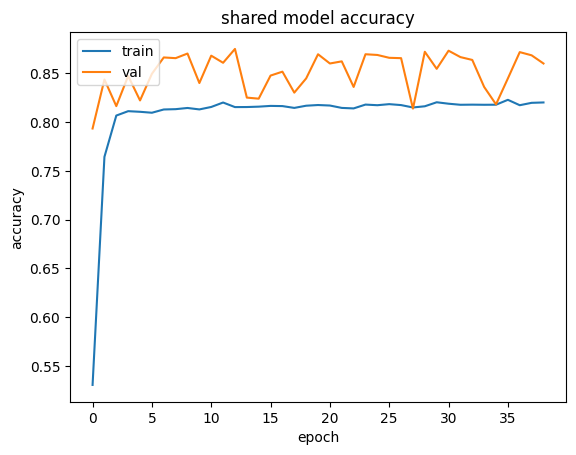

In [82]:
plot_shared(shared_history)

In [83]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model_'+subset+'.h5')
shared.save(trained_model)

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Load Saved Model and Evaluate

In [84]:
shared_trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model_'+subset+'.h5')
shared_model = load_model(shared_trained_model)

In [85]:
x_test,y_test = generate_inputs_shared(vec_test,args,indexes)

print("Evaluate on test data")

results = shared_model.evaluate(x_test, y_test, batch_size=batch_size)
y_pred_shared = shared_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
246/246 [==============================] - 2s 3ms/step
test loss, test acc: [0.4075116813182831, 0.8205814957618713]


In [86]:
m1_y_test = y_test.argmax(axis=1)
m1_y_pred = y_pred_shared.argmax(axis=1)

Classification Report

In [87]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

  O_ACCEPTED       0.66      0.96      0.78       743
 O_CANCELLED       0.59      0.43      0.50      1076
   O_CREATED       1.00      1.00      1.00      2065
  O_DECLINED       0.00      0.00      0.00       250
  O_SELECTED       0.94      0.51      0.66       549
      O_SENT       1.00      1.00      1.00      2069
 O_SENT_BACK       0.55      0.78      0.64      1090

    accuracy                           0.82      7842
   macro avg       0.68      0.67      0.65      7842
weighted avg       0.81      0.82      0.80      7842



Confusion Matrix

[[ 716   10    0    2    7    0    8]
 [  85  458    0    0    8    0  525]
 [   0    0 2065    0    0    0    0]
 [ 230    6    0    0    1    0   13]
 [  44   68    0    0  280    0  157]
 [   0    0    0    0    0 2069    0]
 [  14  228    0    0    1    0  847]]


<Axes: >

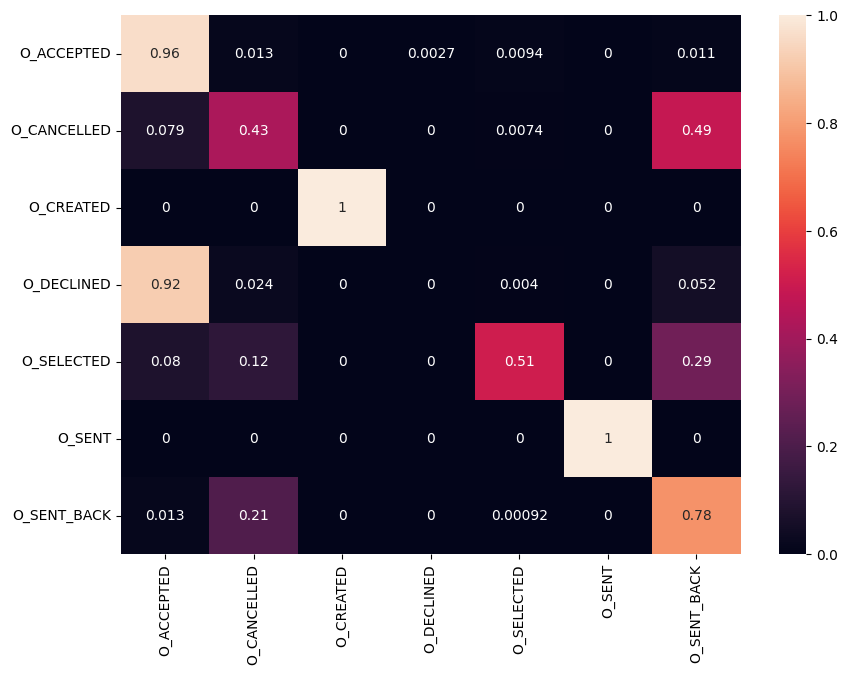

In [88]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

#### specialised Model

In [89]:
specialised = specialised_model(vec_train, weights, indexes, pre_index, args)


In [90]:
specialised.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [91]:
specialised.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ac_input (InputLayer)       [(None, 5, 6)]               0         []                            
                                                                                                  
 rl_input (InputLayer)       [(None, 5, 60)]              0         []                            
                                                                                                  
 t_input (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 beta_ac (Bidirectional)     (None, 5, 100)               22800     ['ac_input[0][0]']            
                                                                                            

In [92]:
batch_size = 64 # 32, 64, 128, 256
epochs = 200

In [93]:
specialised_history = specialised_model_fit(vec_train, specialised, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

This is the output file path  c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\Shared-and-Specialised-Attention-based-Interpretable-Models\BPIC12\models\model_specialised_All_{epoch:02d}-{val_loss:.2f}.h5
Epoch 1/200


244/244 [==============================] - 30s 71ms/step - loss: 1.6049 - accuracy: 0.4971 - val_loss: 1.2549 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 2/200
244/244 [==============================] - 14s 58ms/step - loss: 1.1417 - accuracy: 0.6934 - val_loss: 0.9309 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 3/200
244/244 [==============================] - 14s 58ms/step - loss: 0.9435 - accuracy: 0.7197 - val_loss: 0.7681 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 4/200
244/244 [==============================] - 14s 58ms/step - loss: 0.8376 - accuracy: 0.7296 - val_loss: 0.6731 - val_accuracy: 0.8117 - lr: 0.0010
Epoch 5/200
244/244 [==============================] - 15s 59ms/step - loss: 0.7708 - accuracy: 0.7318 - val_loss: 0.6109 - val_accuracy: 0.8128 - lr: 0.0010
Epoch 6/200
244/244 [==============================] - 14s 58ms/step - loss: 0.7248 - accuracy: 0.7410 - val_loss: 0.5635 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 7/200
244/244 [==============================] - 14s 58ms/

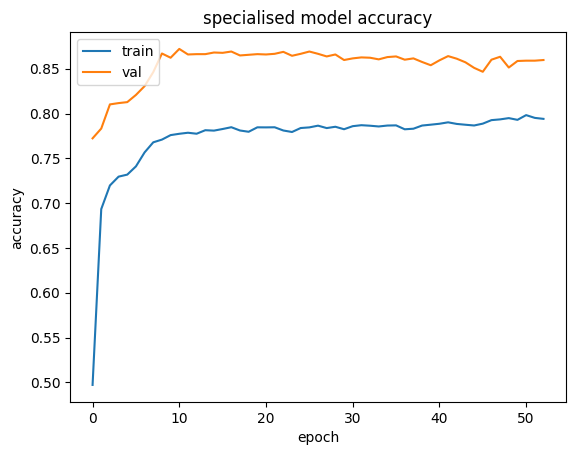

In [94]:
plot_specialised(specialised_history)

In [95]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model_'+subset+'.h5')
specialised.save(trained_model)

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Load Saved Model and Evaluate

In [96]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model_'+subset+'.h5')
specialised_model = load_model(trained_model)

Evaluating Prediction Performance

In [97]:
# Generating Inputs

x_test,y_test = generate_inputs(vec_test,args,indexes,experiment)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = specialised_model.evaluate(x_test, y_test, batch_size=batch_size)
y_pred = specialised_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
246/246 [==============================] - 5s 9ms/step
test loss, test acc: [0.4081331193447113, 0.8161183595657349]


In [98]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

  O_ACCEPTED       0.65      0.97      0.78       743
 O_CANCELLED       0.56      0.44      0.49      1076
   O_CREATED       1.00      1.00      1.00      2065
  O_DECLINED       0.00      0.00      0.00       250
  O_SELECTED       1.00      0.50      0.66       549
      O_SENT       1.00      1.00      1.00      2069
 O_SENT_BACK       0.54      0.73      0.62      1090

    accuracy                           0.82      7842
   macro avg       0.68      0.66      0.65      7842
weighted avg       0.81      0.82      0.80      7842



Confusion Matrix

[[ 718   20    0    0    0    0    5]
 [  90  477    0    0    0    0  509]
 [   0    0 2065    0    0    0    0]
 [ 231    6    0    0    0    0   13]
 [  44   79    2    1  273    0  150]
 [   0    0    0    0    0 2069    0]
 [  15  277    0    0    0    0  798]]


<Axes: >

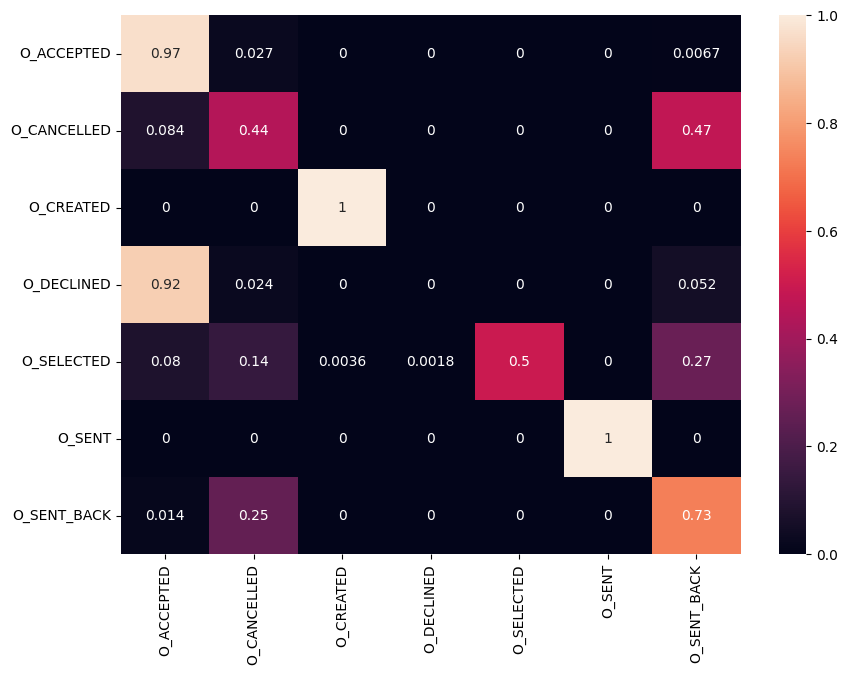

In [99]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [100]:
m2_y_test = y_test.argmax(axis=1)
m2_y_pred = y_pred.argmax(axis=1)
st = pd.DataFrame({"y_test": m2_y_test, "m1_y_pred" : m1_y_pred, "m2_y_pred":m2_y_pred})
st.to_csv("st_O.csv")

import scipy.stats as stats
stats.ttest_ind(st['m1_y_pred'], st['m2_y_pred'])

TtestResult(statistic=1.680048300967874, pvalue=0.09296783626884411, df=15682.0)